## Max Fine

# imports and constants 

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import math
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad


# constants
# define some constants
M = 4.2E6            # Mass of Sgr A* in M_sun
M_sun = 1.988e33     # Solar mass in g
Ledd = 1.26e38 * M   # Eddington luminosity in erg/s
c = 2.997e10         # Speed of light in vaccum in cm/s
G = 6.67e-8          # Gravitational constant in erg cm/g^2
rg = G*M*M_sun/c**2  # Gravitational radius in cm
me = 9.1e-28         # Electron mass in g
m_e = me
e = 4.8e-10          # Electron charge in esu
eta = 1e-7           # radiative efficiency
R0 = 10*rg           # beginning radius of the blob in cm
gam = 1000           # we know this from measurements
p = 2                # power law index
D = 26670*9.461e+17  # Distance to Sgr A* in cm
h = 6.626e-27 # cgs # double check

erg_to_jy = 1e23


eta_values = np.linspace(0.1, 1.5, 5) # no units
r = np.logspace(0, 3, 500)* rg #rg in cm
freq_arr = np.logspace(10, 14, 1000) # hz
dr = np.ediff1d(r) # fancy 

theta = math.radians(10)  #opening angle of 10 degrees converted to radiants 
v = 0.3 * c  # (cm/s)
L_j = 9e37  # Accretion power (erg/s)
power_law_index = p

# copied functions from MC tutorial, slightly edited the main function

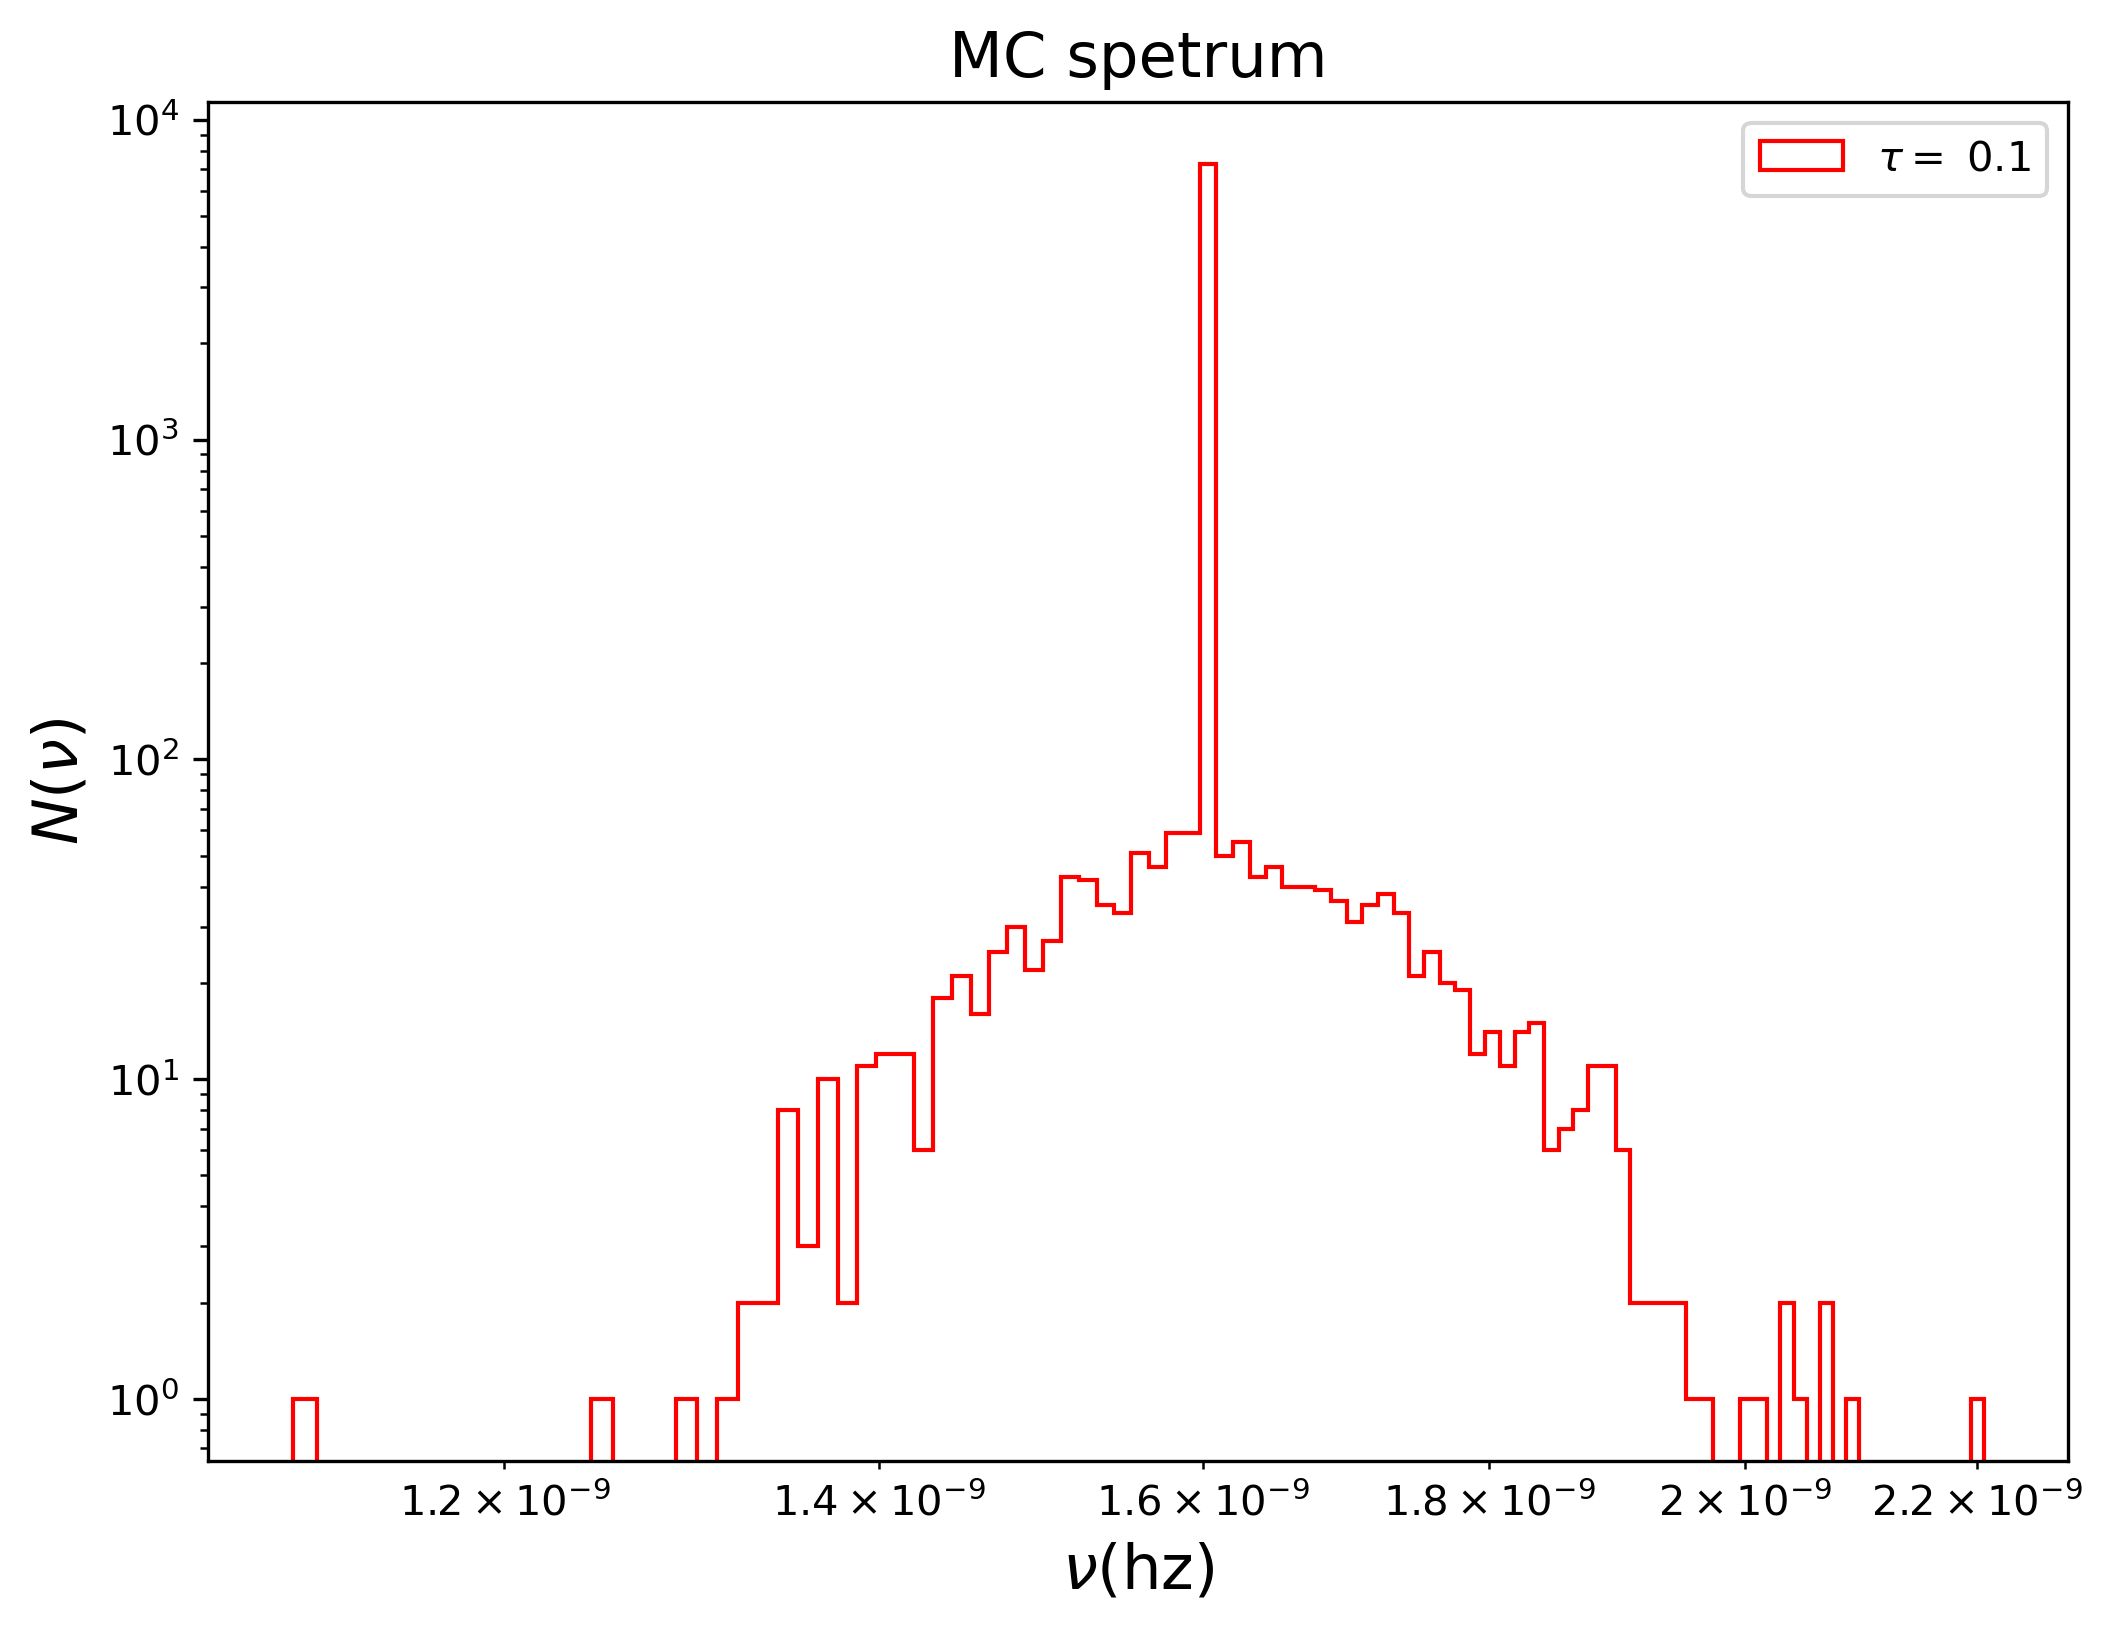

Fraction of escaping photons: 8.610e-01

Compton y parameter: 2.259e-03



/tmp/ipykernel_27515/197357880.py:167: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


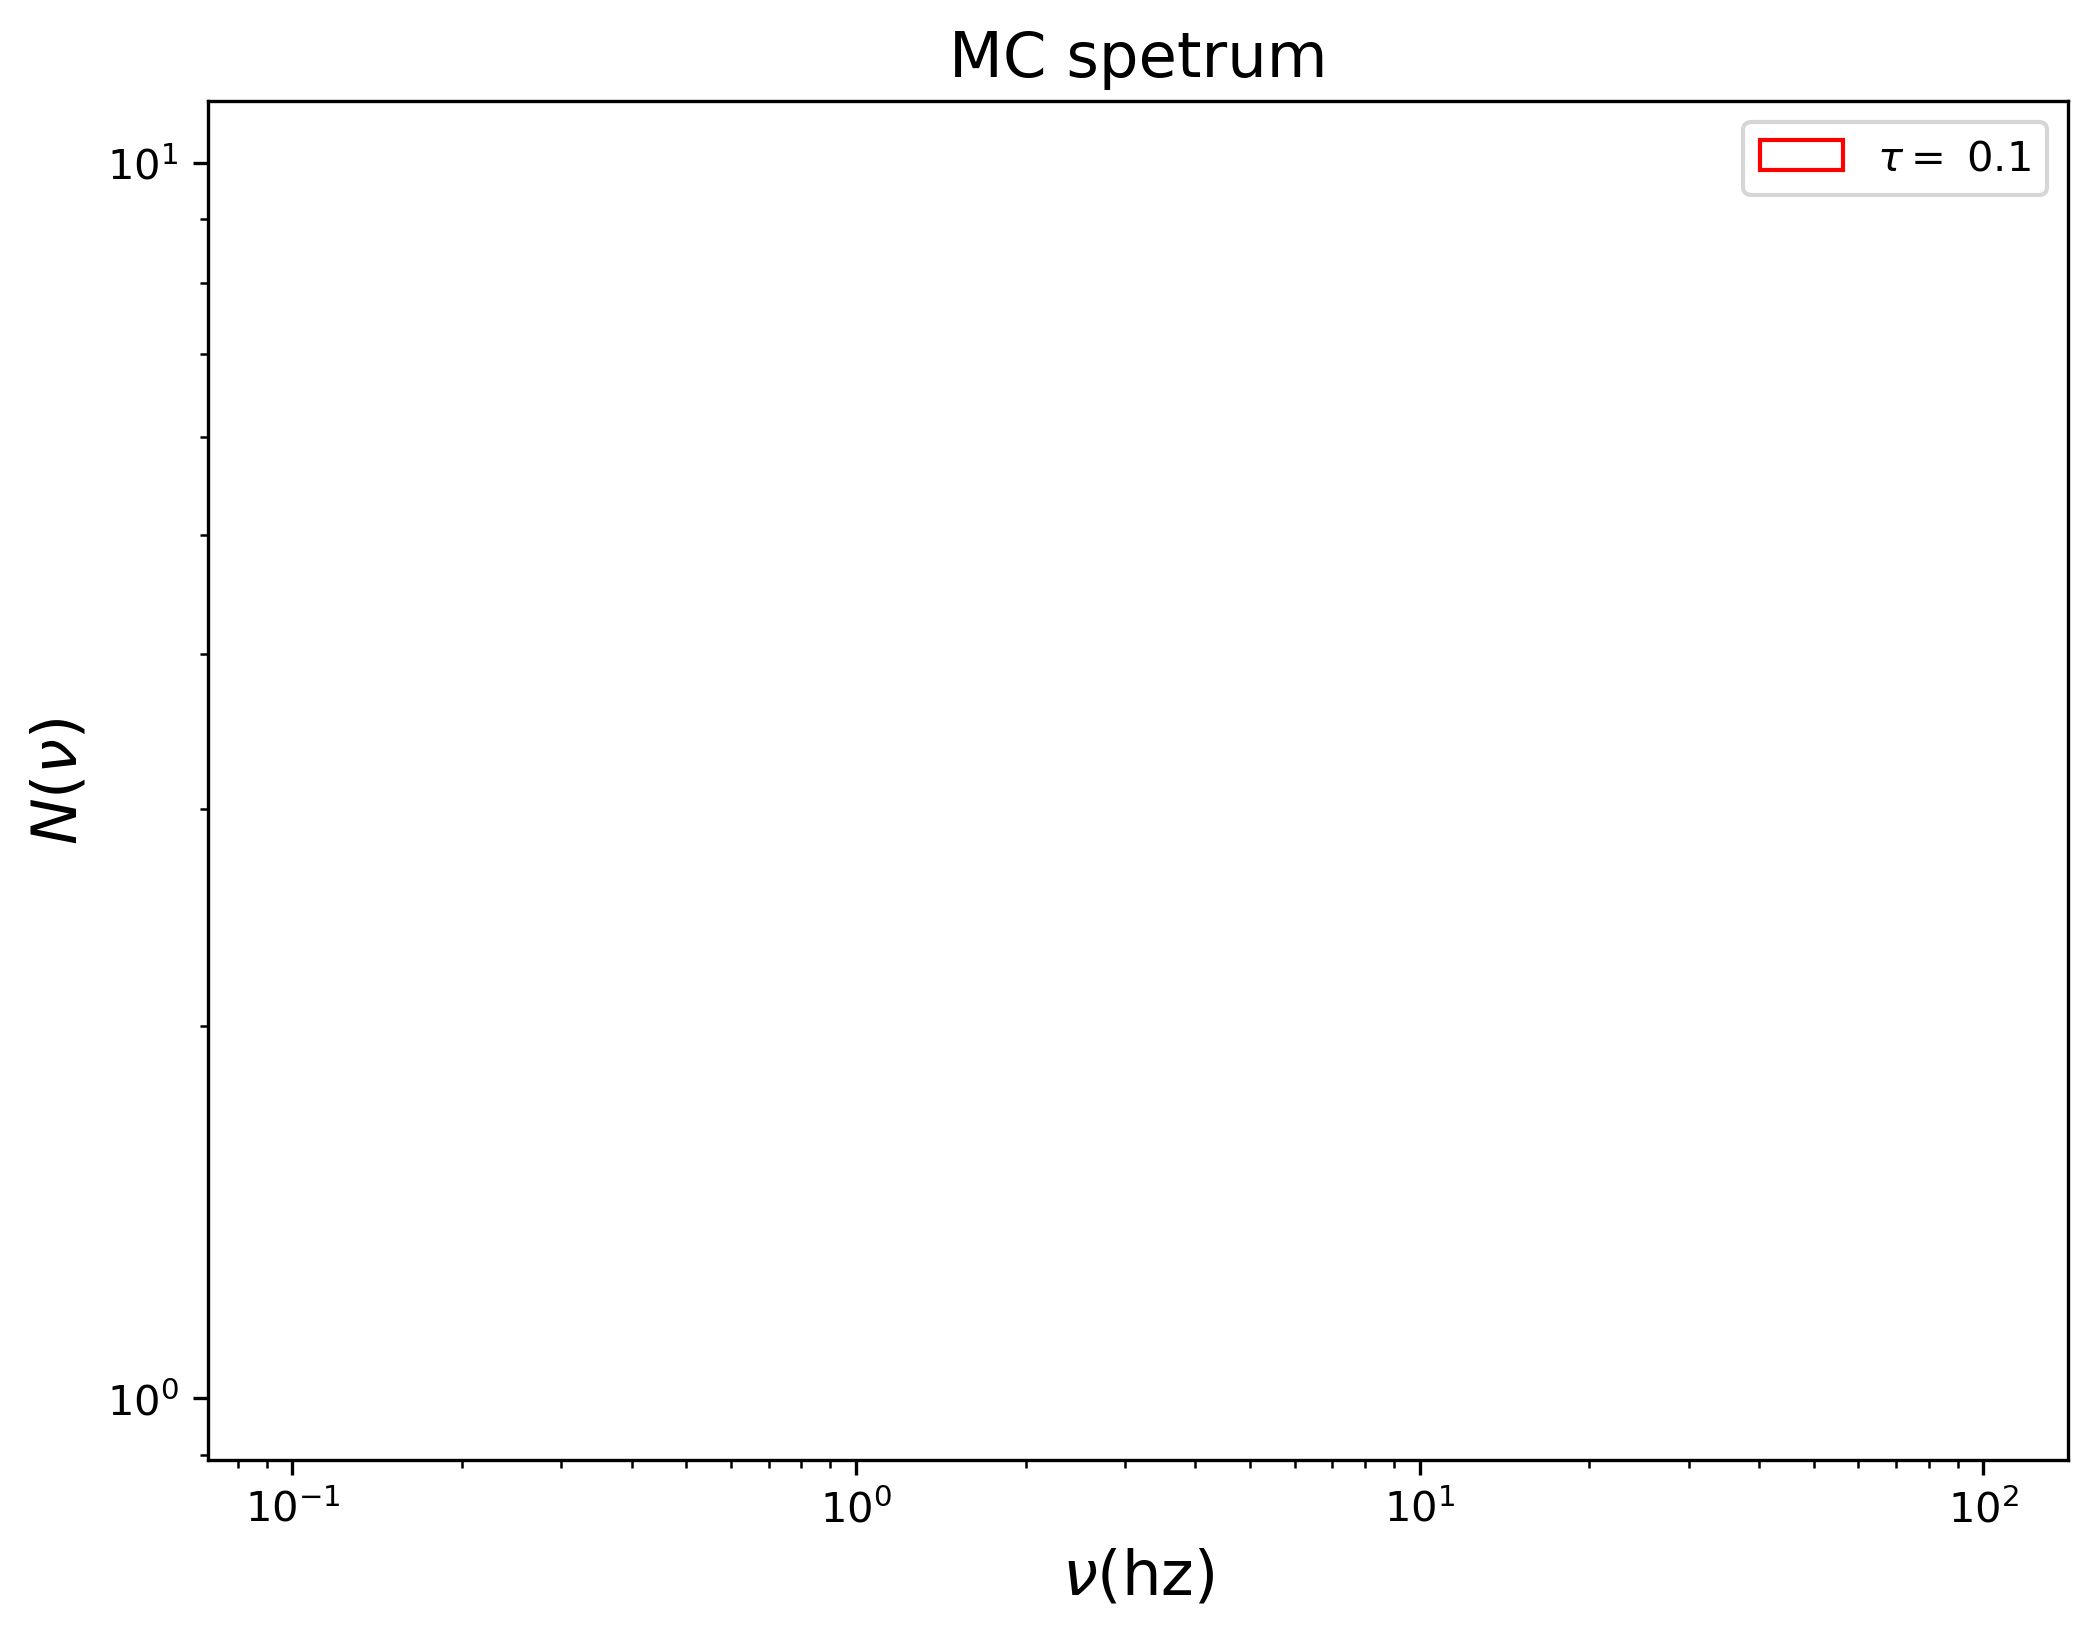

Fraction of escaping photons: 8.540e-01

Compton y parameter: 3.367e-02



/tmp/ipykernel_27515/197357880.py:197: RuntimeWarning: overflow encountered in exp
  return x**2/(np.exp(x)-1)/norm
/tmp/ipykernel_27515/197357880.py:167: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


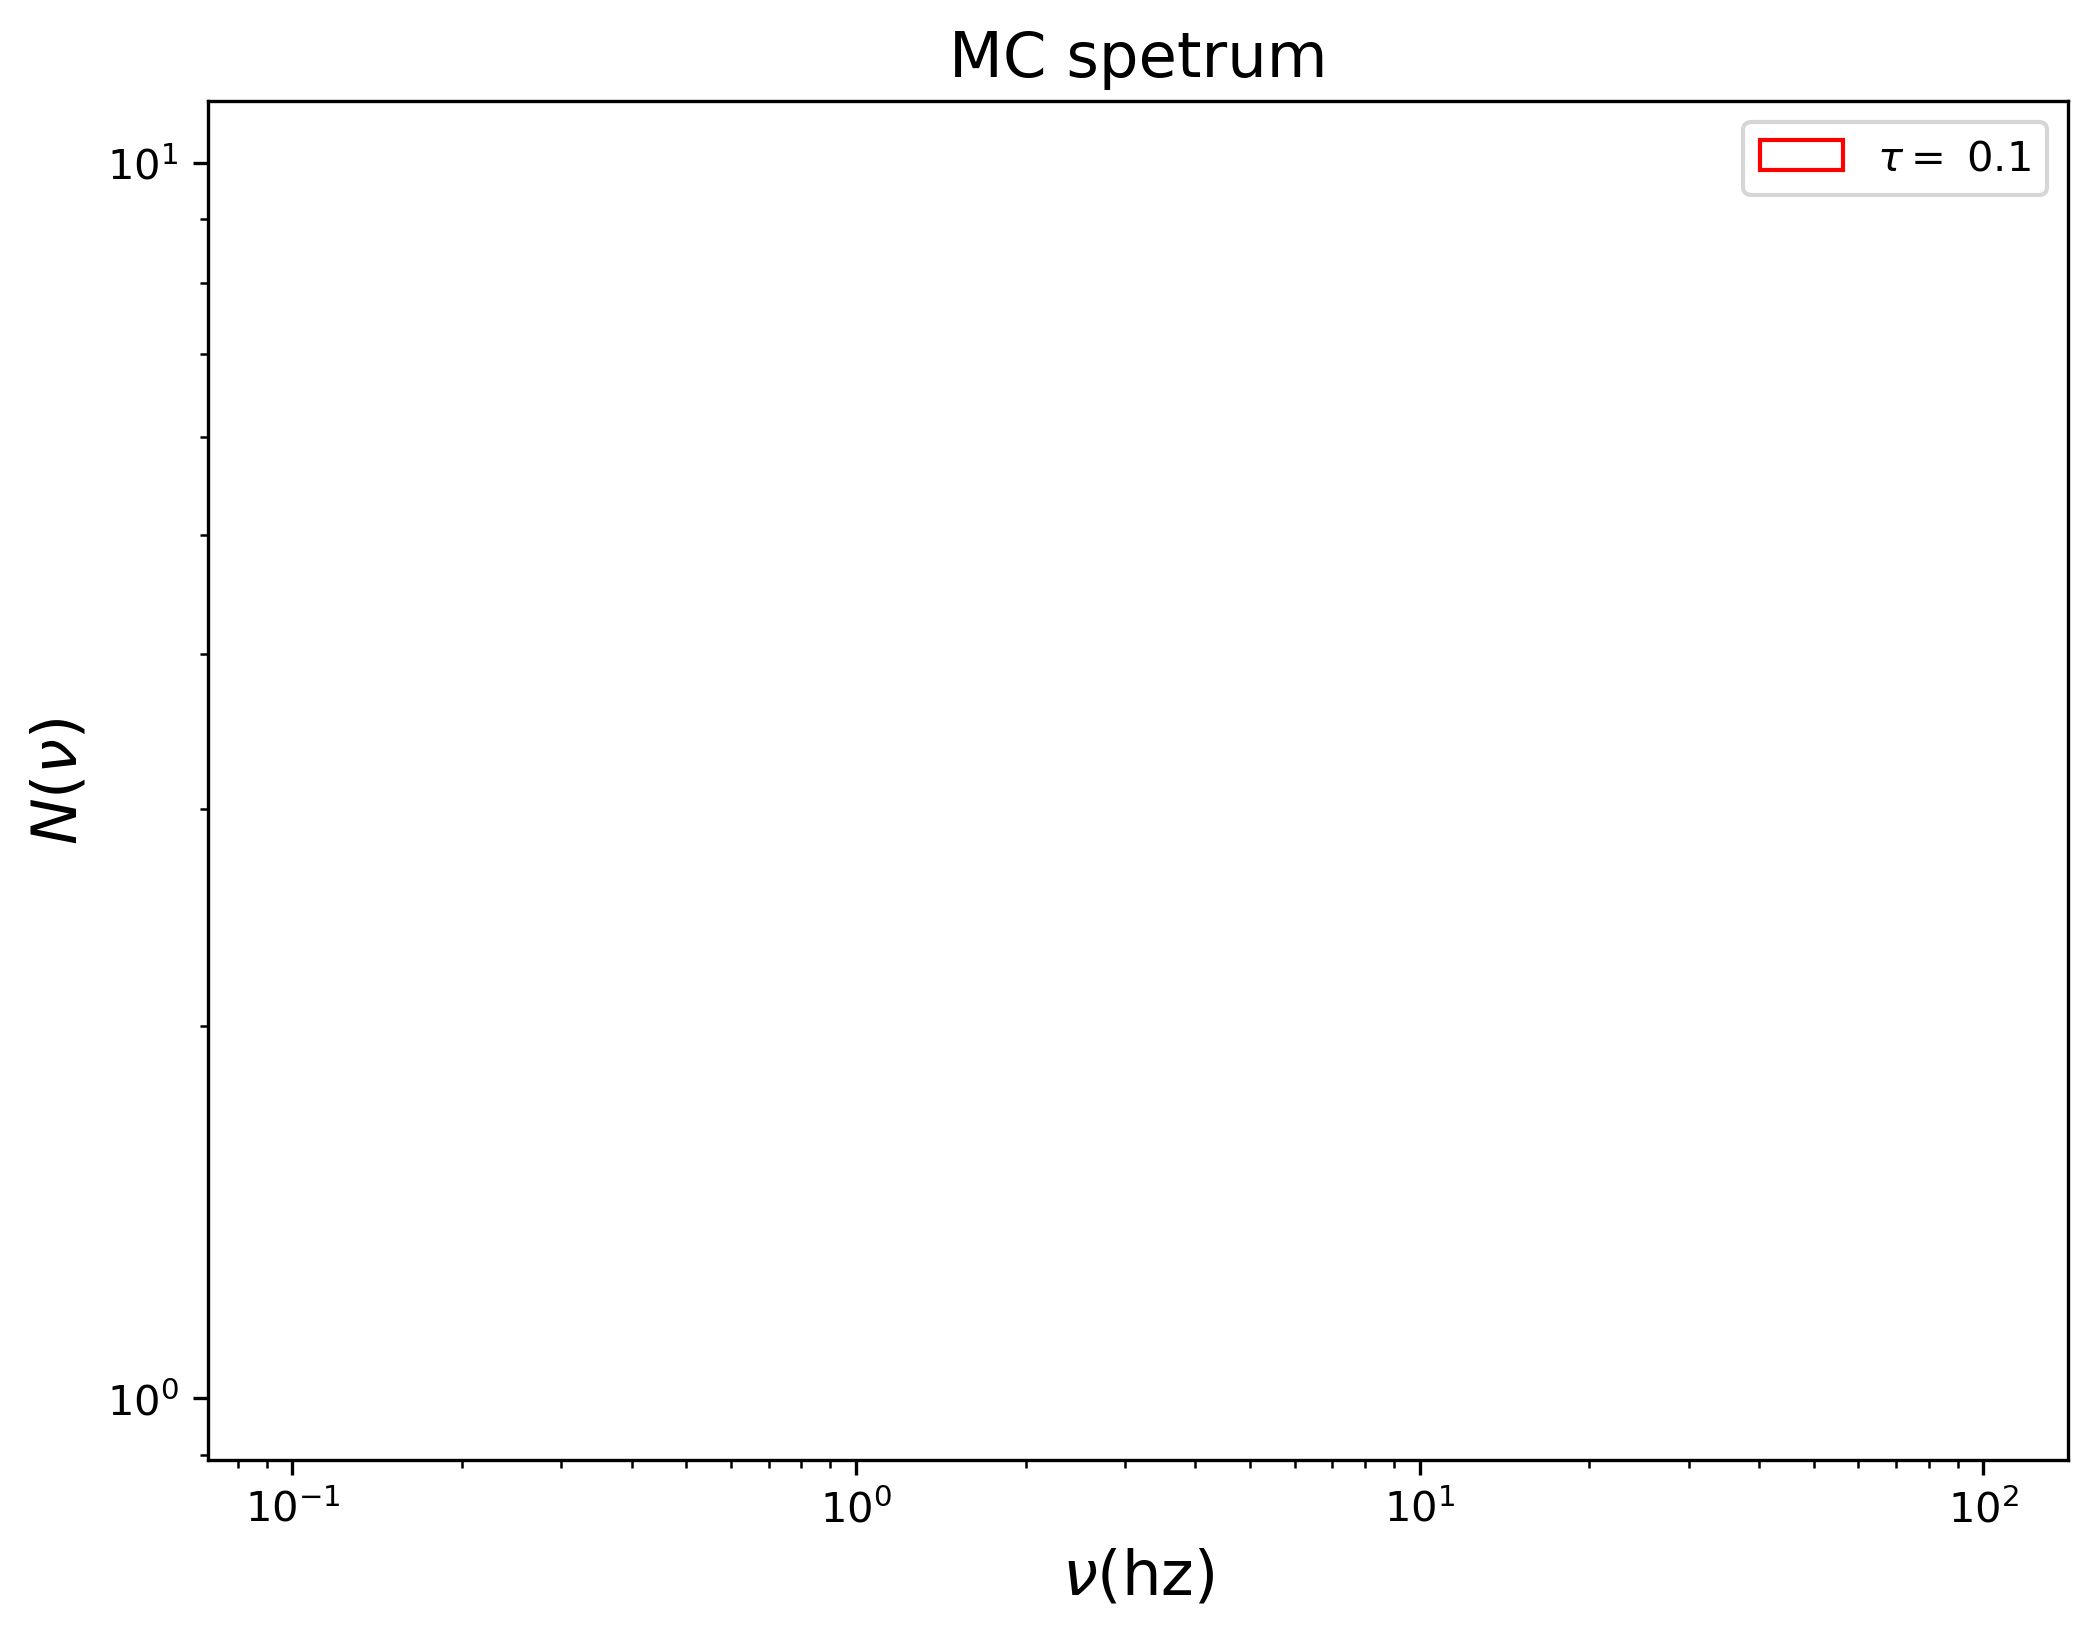

Fraction of escaping photons: 8.572e-01

Compton y parameter: 3.518e-02



In [17]:
# copied from MC tutorial



c_light=3.e10              
m_electron=9.10938356e-28  
sigma_t=6.65e-25           
figure_counter=0           

def compton_y(pre,post):
    y = np.mean((post-pre)/pre)
    return(y)

def random_direction(number=None):
    if number is None:
        number=1
    phi=np.random.rand(number)*2.*np.pi
    cos_theta=2.*np.random.rand(number)-np.ones(number)
    sin_theta= np.sqrt(1-cos_theta**2)
    return((np.array([sin_theta*np.cos(phi),sin_theta*np.sin(phi),cos_theta])).transpose())

def f_of_hnu_mono(mc_parms,number=None):
    if number is None:
        number=1
    return(np.ones(number)*mc_parms['kt_seeds'])

def photon_origin(number=None):
    if number is None:
        number=1
    return(np.zeros([number,3]))

def draw_seed_photons(mc_parms,number=None):
    if number is None:
        number=1
    x_seed=photon_origin(number=number)
    n_seed=random_direction(number=number)
    hnu=mc_parms['hnu_dist'](mc_parms,number=number)
    p_seed=(np.array([hnu,hnu*n_seed[:,0],hnu*n_seed[:,1],hnu*np.abs(n_seed[:,2])])).transpose()/c_light
    return(p_seed,x_seed)

def tau_of_scatter():
    return(-np.log(np.random.rand()))

def distance_of_scatter(mc_parms):
    tau=tau_of_scatter()
    electron_density=mc_parms['tau']/mc_parms['H']/sigma_t
    distance=tau/sigma_t/electron_density    
    return(distance)

def scatter_location(x_old,p_photon,mc_parms):
    distance = distance_of_scatter(mc_parms)
    photon_direction=p_photon[1:]/p_photon[0]
    x_new = x_old + distance*photon_direction
    return(x_new)

def f_of_v_mono(mc_parms):
    return(mc_parms['velocity'])

def draw_electron_velocity(mc_parms,p_photon):
    v=mc_parms['v_dist'](mc_parms)
    n=draw_electron_direction(v,p_photon)
    return(v*n)

def draw_electron_direction(v,p_photon):
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=mu_of_p_electron(v/c_light,np.random.rand())
    sint=np.sqrt(1 - cost**2)
    
    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)
    
    # express new vector in old base
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    return(n_new/np.sqrt(np.sum(n_new**2)))

def mu_of_p_electron(beta,p):
    mu=1/beta-np.sqrt(1/beta**2 + 1 - 4*p/beta + 2/beta)
    return(mu)

def lorentz_transform(p,v):
    beta=np.sqrt(np.sum(v**2))/c_light
    beta_vec=v/c_light
    gamma=1./np.sqrt(1. - beta**2)
    matrix=np.zeros((4,4))
    matrix[0,0]=gamma
    matrix[1:,0]=-gamma*beta_vec
    matrix[0,1:]=-gamma*beta_vec
    matrix[1:,1:]=(gamma-1)*np.outer(beta_vec,beta_vec)/beta**2
    for i in range(1,4):
        matrix[i,i]+=1
    return(np.dot(matrix,p))

def cos_theta_thomson(p):
    a=-4 + 8*p
    b=a**2 + 4
    return((np.power(2,1/3)*np.power(np.sqrt(b)-a,2/3)-2)/
           (np.power(2,2/3)*np.power(np.sqrt(b)-a,1/3)))

def thomson_scatter(p_photon):
    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=cos_theta_thomson(np.random.rand())
    sint=np.sqrt(1 - cost**2)
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    n_new/=np.sqrt(np.sum(n_new**2))
    return(np.array(p_photon[0]*np.array([1,n_new[0],n_new[1],n_new[2]])))

def inverse_compton_scatter(p_photon,mc_parms):
    velocity=draw_electron_velocity(mc_parms,p_photon)
    p_photon_prime=lorentz_transform(p_photon,velocity)
    p_out_prime=thomson_scatter(p_photon_prime)
    return(lorentz_transform(p_out_prime,-velocity))

def monte_carlo(mc_parms):
    hnu_seed=np.zeros(mc_parms['n_photons'])
    hnu_scattered=hnu_seed.copy()
    p_photons,x_photons=draw_seed_photons(mc_parms,number=mc_parms['n_photons'])
    for p_photon,x_photon,i in zip(p_photons,x_photons,range(mc_parms['n_photons'])):
        hnu_seed[i]=p_photon[0]*c_light
        scattered=True

        # new code here
        #############################################################################
       # nu_photon = p_photon * c / h # hopefully the freq of the photon
       # print('nu photon is', nu_photon)
       # mc_parms['tau'] = optical_depth(r[0], nu_photon ,p)/mc_parms['H']/sigma_t
        ###########################################################################

        while (scattered):
            x_photon = scatter_location(x_photon,p_photon,mc_parms)
            if (x_photon[2]>=0 and x_photon[2]<=mc_parms['H']):
                p_photon=inverse_compton_scatter(p_photon,mc_parms)
            else:
                scattered=False
                if (x_photon[2]<=0):
                    p_photon*=0
        hnu_scattered[i]=p_photon[0]*c_light
    return(hnu_scattered[hnu_scattered > 0],hnu_seed[hnu_scattered > 0])

def plot_mc(mc_parms,bins=None,xlims=None,filename=None):
    global figure_counter
    if (xlims is None):
        xlims=[0.1,100]    
    if (bins is None):
        bins=np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),num=100)
    if (filename is None):
        filename='hw_5_plot_{0:d}.pdf'.format(figure_counter)
    hnu_scattered,hnu_seeds=np.array(monte_carlo(mc_parms))# /mc_parms['kt_seeds'] 
    fig=plt.figure(figsize=(8,6), dpi=300)
    plt.hist(hnu_scattered,bins=bins,log=True,
             label=r'$\tau=${:4.1f}'.format(mc_parms['tau']), histtype='step', color='red')
    plt.xscale('log')
    #plt.xlim(xlims[0],xlims[1])
    #plt.xlabel(r'$h\nu/h\nu_{0}$')
    plt.xlabel(r'$\nu$(hz)', size=15)
    plt.ylabel(r'$N(\nu)$', size=15)
    plt.title('MC spetrum', size=15)
    plt.legend()
    fig.savefig(filename)
    figure_counter+=1
    plt.show()
    print('Fraction of escaping photons: {0:5.3e}\n'.format(hnu_scattered.size/mc_parms['n_photons']))
    print('Compton y parameter: {0:5.3e}\n'.format(compton_y(hnu_seeds,hnu_scattered)))
    return(hnu_scattered,hnu_seeds)

mc_parms={'n_photons':10000,'kt_seeds':1.6e-9,'H':1e7,'velocity':3e9,'tau':0.1,'v_dist':f_of_v_mono,'hnu_dist':f_of_hnu_mono}

hnu_scattered,hnu_seeds=plot_mc(mc_parms,bins=100)

def f_of_v_maxwell(mc_parms):
    v=3e10
    while v >= c_light:
        v=np.sqrt(mc_parms['kt_electron']/(m_electron))*np.sqrt(np.sum((np.random.normal(0,1,3))**2))
    return(v)

mc_parms={'n_photons':10000,'kt_seeds':1.6e-9,'H':1e7,'velocity':3e9,'tau':0.1,'kt_electron':3.2e-8,'v_dist':f_of_v_maxwell,'hnu_dist':f_of_hnu_mono}
mc_parms['velocity']=np.sqrt(mc_parms['kt_electron']/(m_electron))
hnu_scattered,hnu_seeds=plot_mc(mc_parms)

def f_planck(x):
    norm=2.4041138063192817
    return x**2/(np.exp(x)-1)/norm

def p_planck(hnu=None):
    if (hnu is None):
        number=1000
        hnu=np.append(np.linspace(0,1-1./number,number),np.logspace(0,4,number))

    p=np.zeros(2*number)
    for i in range(1,2*number):
        p[i]=((quad(f_planck,0,hnu[i]))[0])
    return (p,hnu)

def hnu_of_p_planck(number=None,pdf=None,hnu=None):
    if number is None:
        number=1
    if (pdf is None):
        pdf,hnu=p_planck()

    e_phot=np.interp(np.random.rand(number),pdf,hnu)
    return(e_phot,pdf,hnu)

def f_of_hnu_planck(mc_parms,number=None,pdf=None,energies=None):
    if number is None:
        number=1
    if (pdf is None):
        e,pdf,energies=hnu_of_p_planck(number=number)
    else:
        e,pdf,energies=hnu_of_p_planckl(number=number,pdf=pdf,hnu=energies)        
    e*=mc_parms['kt_seeds']    
    return(e)

mc_parms={'n_photons':10000,'kt_seeds':1.6e-9,'H':1e7,'tau':0.1,'kt_electron':3.2e-8,'v_dist':f_of_v_maxwell,'hnu_dist':f_of_hnu_planck}
hnu_scattered,hnu_seeds=plot_mc(mc_parms)

# code from PS4
informed my solutions were correct but use the correct frequency min and max value by marker

In [4]:
# copied from PS4


def magnetic_field_strength(distance):
    """
    Calculate the magnetic field strength.

    Parameters:
    - distance (float): Distance from the source.

    Returns:
    float: Magnetic field strength.
    """
    return np.sqrt(L_j / v) * 4/ distance  # other ppl have this factor of 4, whereas I dont have this
                                           # i think my solution for 1a is missing a factor of 4


def constant_parameter(distance):
    """
    Calculate a constant parameter C.

    Parameters:
    - distance (float): Distance above the source.

    Returns:
    float: Constant parameter C.
    """
    return (magnetic_field_strength(distance))**2 / (24 * np.log(10) * np.pi)


def synchrotron_emission_coef(distance, frequency, power_law_index):
    """
    Calculate the synchrotron emission coefficient.

    Parameters:
    - distance (float): Distance above the source.
    - frequency (float): Frequency.
    - power_law_index (float): Power-law index.

    Returns:
    float: Synchrotron spectral index.
    """
    part1 = np.sqrt(3) * e**3 / (8 * np.pi * m_e)
    part2 = (3 * e / (2 * np.pi * m_e**3 * c**5))**(power_law_index/2)
    part3 = constant_parameter(distance) * (magnetic_field_strength(distance)/2)**((power_law_index+2)/2) * gamma((3*power_law_index + 2)/12)
    part4 = gamma((3*power_law_index + 22)/12) * frequency**((-power_law_index-4)/2)
    return part1 * part2 * part3 * part4

def S_freq(distance, frequency, power_law_index):
    """
    Calculate the synchrotron source function.

    Parameters:
    - distance (float): Distance above the source.
    - frequency (float): Frequency.
    - power_law_index (float): Power-law index.

    Returns:
    float: Synchrotron source function.
    """
    return synchrotron_power(distance, frequency, power_law_index)/(4 * np.pi * synchrotron_emission_coef(distance, frequency, power_law_index))
    



def synchrotron_power(distance, frequency, power_law_index):
    """
    Calculate the synchrotron power.

    Parameters:
    - distance (float): Distance above the source
    - frequency (float): Frequency.
    - power_law_index (float): Power-law index.

    Returns:
    float: Synchrotron power.
    """
    part1 = np.sqrt(3) * e**3 * constant_parameter(distance) / (m_e * c**2) * magnetic_field_strength(distance) / (2 * m_e * c**2 * (power_law_index+1))
    part2 = gamma(power_law_index/4 + 19/12) * gamma(power_law_index/4 - 1/12) * (4 * np.pi * m_e * c * frequency/(3 * e * magnetic_field_strength(distance)))**((1-power_law_index)/2)
    return part1 * part2


def optical_depth(distance, frequency, power_law_index):
    """
    Calculate the optical depth.

    Parameters:
    - distance (float): Distance above the source.
    - frequency (float): Frequency.
    - power_law_index (float): Power-law index.

    Returns:
    float: Optical depth.
    """
    return synchrotron_emission_coef(distance, frequency, power_law_index) * distance



def I_freq(distance, frequency, power_law_index):
    """
    Calculate the synchrotron intensity.

    Parameters:
    - distance (float): Distance above the source.
    - frequency (float): Frequency.
    - power_law_index (float): Power-law index.

    Returns:
    float: Synchrotron intensity.
    """
    return S_freq(distance, frequency, power_law_index) * (1 - np.exp(-optical_depth(distance, frequency, power_law_index)))

def flux(distance, frequency, power_law_index, differential_distance, target_distance):
    """
    Calculate the synchrotron flux.

    Parameters:
    - distance (float): Distance above the source
    - frequency (float): Frequency.
    - power_law_index (float): Power-law index.
    - differential_distance (float): Differential distance.
    - target_distance (float): Distance to the target. 

    Returns:
    float: Synchrotron flux in ergs (CGS Units).
    """
    return  I_freq(distance, frequency, power_law_index) * distance * differential_distance * np.tan(theta/2) /(  4 * target_distance**2)


# new code for making photon spectrum from the base of the jet

In [5]:
## new code for photon spectrum

def jet_spectrum_pdf(r, freq_arr, power_law_index):

    I_v = I_freq(r, freq_arr, power_law_index)
    n_photons = I_v  / (h*freq_arr)

    return (I_v  / (h*freq_arr) ) #/ np.sum(n_photons)


def sample_jet_spectrum(n, jet_pdf, freq_arr):

    '''modified from the demo.ipynb from week 1'''

    jet_pdf = jet_pdf / np.sum(jet_pdf)
    cdf = np.cumsum(jet_pdf)
    # Generate n random numbers from a uniform distribution between 0 and 1
    u = np.random.uniform(0, 1, size=n)
    # Interpolate the inverse cdf function using numpy.interp
    v_inv = np.interp(u, cdf, freq_arr)
    # Return the sampled energies array
    return v_inv # this is photon energy?







1578976007211515.0
1000


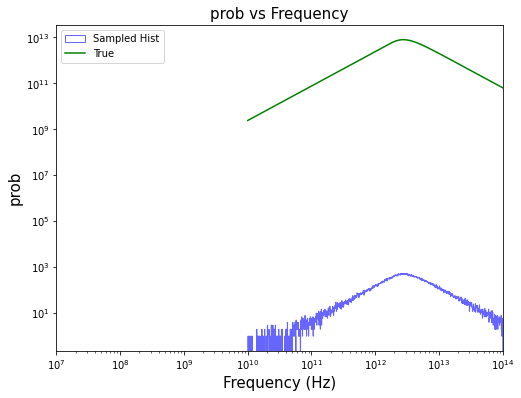

In [6]:
# plot to check

jet_pdf = jet_spectrum_pdf(r[0], freq_arr, power_law_index)
samples = sample_jet_spectrum(int(1e5), jet_pdf, freq_arr)
plt.figure(figsize=(8,6))
plt.hist(samples , bins=freq_arr, alpha=0.6, color='b', log=True, histtype='step', label='Sampled Hist')
#plt.axvline(v_peak, c="orange", ls="--")
plt.xlabel('Frequency (Hz)', size = 15)
plt.ylabel('prob', size = 15)
plt.title('prob vs Frequency', size = 15)
#plt.yscale('log')
plt.xscale('log')
#plt.yscale('log')


jet_pdf = jet_spectrum_pdf(r[0], freq_arr, power_law_index)

print(np.sum(jet_pdf))


plt.plot(freq_arr, jet_pdf, color='green', label='True')
plt.xlabel('Frequency (Hz)', size = 15)
plt.ylabel('prob', size = 15)
plt.title('prob vs Frequency', size = 15)
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.xlim(1e7, 1e14)
print(len(freq_arr))
plt.show()

# same shape but different y scaling!

# comment on plot:
I think the heights are different due to the number of samples? 
the plot has the right shape, but I cant figure out why the sampled hist is shorter :((

# basically the same but now for electron spectrum
power law with p=2, 

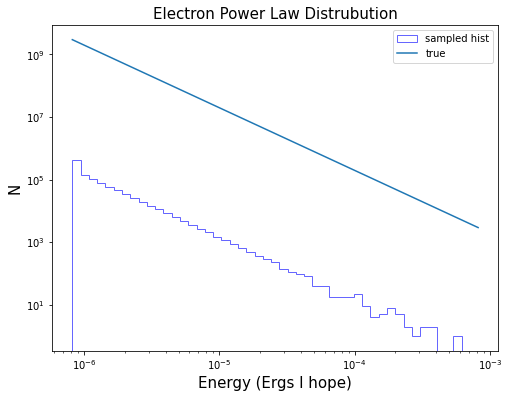

In [7]:

E = np.logspace(0, 3) * m_e*c**2  # gamma from 1 to 10^3
    
def electron_power_law(E, distance, p=2):
    constant = constant_parameter(distance)
    C_hat =  m_e*c**2*constant # maybe I dont include this? which c is it?!?!
    n_e = C_hat*E**-p
    return n_e

n_e = electron_power_law(E, r[0], p=2)



def sample_n_e_spectrum(n, n_e, energy_arr):

    '''modified from the demo.ipynb from week 1'''

    pdf = n_e / np.sum(n_e)
    cdf = np.cumsum(pdf)
    # Generate n random numbers from a uniform distribution between 0 and 1
    u = np.random.uniform(0, 1, size=n)
    # Interpolate the inverse cdf function using numpy.interp
    v_inv = np.interp(u, cdf, energy_arr)
    # Return the sampled energies array
    return v_inv # n? no idea lets try


samples = sample_n_e_spectrum(int(1e6), n_e, E)
plt.figure(figsize=(8,6))
plt.hist(samples, bins=E, alpha=0.6, color='b', log=True, histtype='step', label='sampled hist')
#plt.axvline(v_peak, c="orange", ls="--")
plt.xlabel('energy (ergs???)', size = 15)
plt.ylabel('prob', size = 15)
plt.title('prob vs energy', size = 15)
#plt.yscale('log')
plt.xscale('log')
#plt.yscale('log')
#plt.show()

# verification plots
plt.plot(E, n_e, label='true')
plt.xscale('log')
plt.yscale('log')
plt.title('Electron Power Law Distrubution', size=15)
plt.xlabel('Energy (Ergs I hope)', size=15)
plt.ylabel('N', size=15)
plt.legend()
plt.show()

# same shape but different y scaling!

# comment on plot:
I think the heights are different due to the number of samples? 
the plot has the right shape, but I cant figure out why the sampled hist is shorter :((

# we just need to covert the x axis from E to velocity 

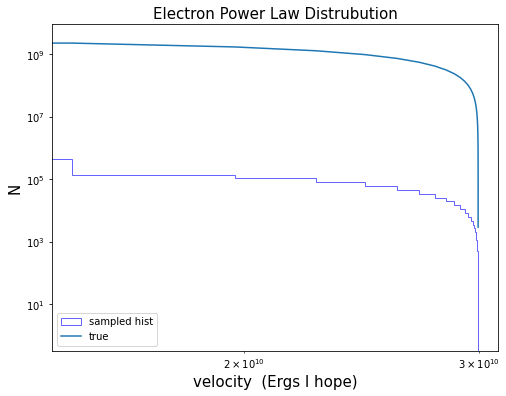

In [8]:
#what we really want is the eletrcon velocilty distrubution not the energy!

# so we gotta do one more thing

def energy_to_velocity(energy, rest_mass=m_e, speed_of_light=c):
    # Calculate the Lorentz factor (gamma)
    gamma = energy / (rest_mass * speed_of_light**2)
    
    # Calculate the velocity using the inverse Lorentz transformation
    velocity = speed_of_light * np.sqrt(1 - 1 / gamma**2)
    
    return velocity


samples = sample_n_e_spectrum(int(1e6), n_e, E)
samples = energy_to_velocity(samples)
plt.figure(figsize=(8,6))
plt.hist(samples, bins=energy_to_velocity(E), alpha=0.6, color='b', log=True, histtype='step', label='sampled hist')
#plt.axvline(v_peak, c="orange", ls="--")
plt.xlabel('Velocity (cgs)', size = 15)
plt.ylabel('prob', size = 15)
plt.title('prob vs energy', size = 15)
#plt.yscale('log')
plt.xscale('log')
#plt.yscale('log')
#plt.show()

# verification plots
plt.plot(energy_to_velocity(E), n_e, label='true')
plt.xscale('log')
plt.yscale('log')
plt.title('Electron Power Law Distrubution', size=15)
plt.xlabel('velocity  (Ergs I hope)', size=15)
plt.ylabel('N', size=15)
plt.legend()
plt.show()


# lets make wrapper functions that work with the given MC code

In [9]:
# wrapper functions that we can use directly with the MC code

def v_power(mc_parms, n_e=n_e, E=E):

    n = 1

    samples = sample_n_e_spectrum(n, n_e, E) # how many samples do we want?
    samples = energy_to_velocity(samples)

    return samples



def f_of_jet_slice(mc_parms, r=r, freq_arr =freq_arr, power_law_index=2, number=None,pdf=None,energies=None):

    if number == None:
        number = 1
    n = number

    jet_pdf = jet_spectrum_pdf(r[0], freq_arr, power_law_index)
    samples = sample_jet_spectrum(n, jet_pdf, freq_arr) # photons chosen at random from the distrubution 

    return samples


/tmp/ipykernel_27515/197357880.py:84: RuntimeWarning: divide by zero encountered in true_divide
  mu=1/beta-np.sqrt(1/beta**2 + 1 - 4*p/beta + 2/beta)
/tmp/ipykernel_27515/197357880.py:84: RuntimeWarning: invalid value encountered in subtract
  mu=1/beta-np.sqrt(1/beta**2 + 1 - 4*p/beta + 2/beta)


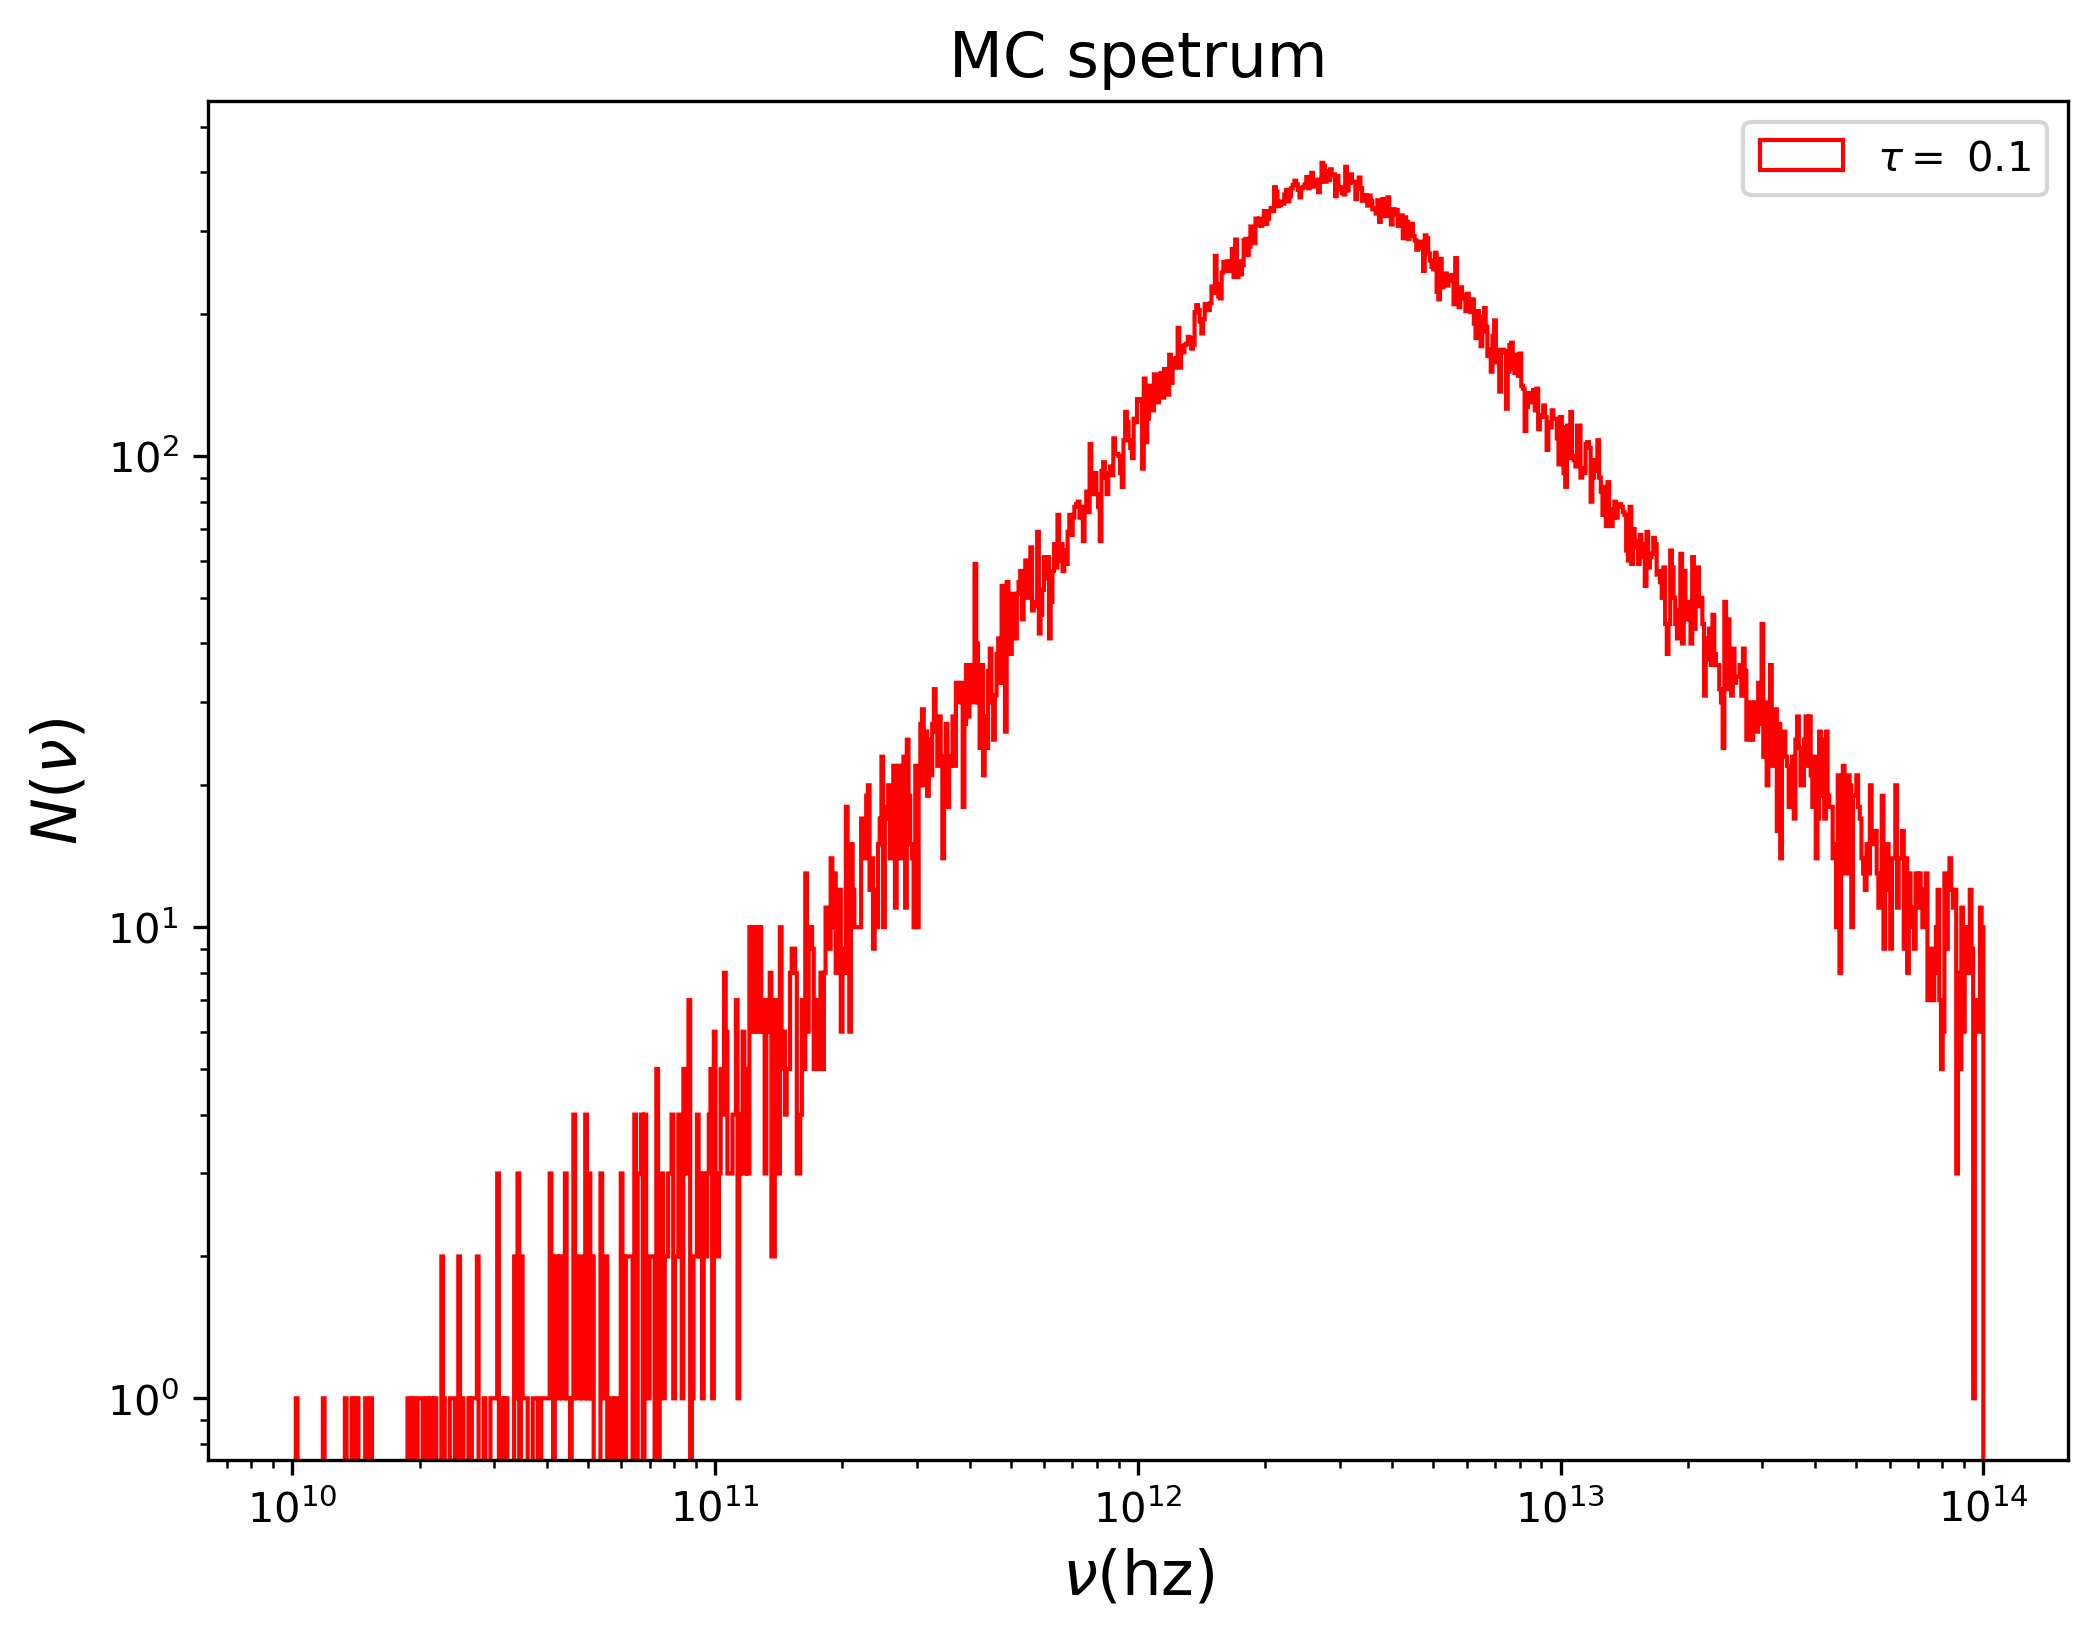

Fraction of escaping photons: 8.151e-01

Compton y parameter: 1.934e+00



In [18]:
# now we just put everything together   

# we make the aformentioned distrubutions prior to this

mc_parms={'n_photons':int(1e5),         # start somewhat small and go up
            'kt_seeds':1.6e-9,         # not sure if it breaks if i take it out
            'H':r[0],                   # r[0]
            'velocity':3e10 * 0.3,            # 30% speed of light-
            'tau':.1,                 # tau ~ 0.1: Small-ish optical depth # t=1 for photosphere
            'v_dist':v_power,      # name of velocity distribution function for electrons
            'hnu_dist':f_of_jet_slice,  # name of photon distribution function
            }
hnu_scattered,hnu_seeds=plot_mc(mc_parms,bins=freq_arr, xlims=[1, 1e10])



# ok, we have a plot! I hope its good, not sure if the x axis is the correct dimensions

# now we want to plot the spectrum of the base of the jet again, and try to normalize 

I talked with a few friends, and we struggled on the coding section and did not have time to figure out how to correctly normalize. I am using the (i think wrong!) method of matching the two peaks of the spectrums - as far as wrong methods go - i dont think its that bad. 

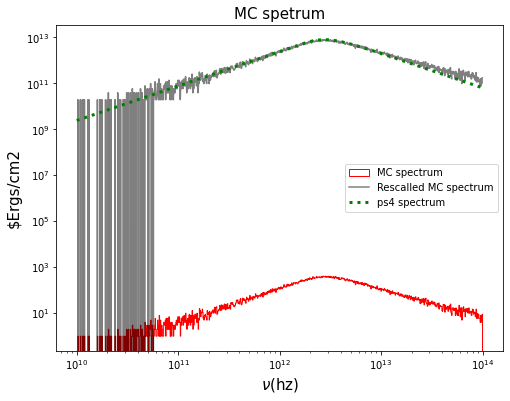

In [11]:
plt.figure(figsize=(8,6))

counts, bins, _ =plt.hist(hnu_scattered,bins=freq_arr,log=True,
             label=r'MC spectrum', histtype='step', color='red')
plt.xscale('log')
plt.xlabel(r'$\nu$(hz)', size=15)
plt.ylabel(r'$Ergs/cm2', size=15)
plt.title('MC spetrum', size=15)


jet_pdf = jet_spectrum_pdf(r[0], freq_arr, power_law_index) # not actually a pdf shh



max_ps4 = np.max(jet_pdf)
max_ps5 = np.max(counts)

normalization = max_ps4/max_ps5

plt.plot(bins[:-1], counts * normalization , color='k', linestyle='-', label='Rescalled MC spectrum', alpha=0.5)



plt.plot(freq_arr, jet_pdf, color='green',linestyle=':', label='ps4 spectrum', linewidth=3)
plt.legend()
plt.show()

# comment:
* i used a cosntant tau for simplicity
* I think my code is wrong, certaintly the rescalling / normalization at the end. I dont think its supposed to match up exactly?
* i'm not sure where else, but but clearly somethig is wrong as we are seeing only a singilar peak, and not a self scattered shorter peaks
* the empty bins seems a bit shady to me, but I think thats because we are not using a super high n_photons, and its a large sampling region
* I am suspicious about the y scale units on this plot
* maybe I am not drawing from the electron powerlaw the way I think I am? I wish we had a tutorial for the tutorial notebook :((
*  maybe its because my other histogram check plots dont match the same y values as what they are supposed to be sampled from?


# 

# project code

In [12]:
def optical_depth(distance, frequency, power_law_index):
    """
    Calculate the optical depth.

    Parameters:
    - distance (float): Distance above the source.
    - frequency (float): Frequency.
    - power_law_index (float): Power-law index.

    Returns:
    float: Optical depth.
    """
    return synchrotron_emission_coef(distance, frequency, power_law_index) * distance


def distance_of_scatter(mc_parms):
    tau=tau_of_jet(mc_parms)
    electron_density=mc_parms['tau']/mc_parms['H']/sigma_t
    distance=tau/sigma_t/electron_density    
    return(distance)


def tau_of_jet(mc_parms):
    return tau

In [13]:
mc_parms

{'n_photons': 100000,
 'kt_seeds': 1.6e-09,
 'H': 620037588472.6902,
 'velocity': 9000000000.0,
 'tau': 0.1,
 'v_dist': <function __main__.v_power(mc_parms, n_e=array([2.93580210e+09, 2.21451077e+09, 1.67043206e+09, 1.26002696e+09,
       9.50453464e+08, 7.16938459e+08, 5.40795288e+08, 4.07928378e+08,
       3.07705274e+08, 2.32105782e+08, 1.75080178e+08, 1.32065081e+08,
       9.96182759e+07, 7.51432616e+07, 5.66814644e+07, 4.27555091e+07,
       3.22509939e+07, 2.43273119e+07, 1.83503834e+07, 1.38419146e+07,
       1.04411223e+07, 7.87586394e+06, 5.94085873e+06, 4.48126107e+06,
       3.38026903e+06, 2.54977751e+06, 1.92332779e+06, 1.45078924e+06,
       1.09434775e+06, 8.25479644e+05, 6.22669206e+05, 4.69686858e+05,
       3.54290436e+05, 2.67245530e+05, 2.01586512e+05, 1.52059126e+05,
       1.14700025e+05, 8.65196056e+04, 6.52627773e+04, 4.92284965e+04,
       3.71336460e+04, 2.80103550e+04, 2.11285471e+04, 1.59375167e+04,
       1.20218602e+04, 9.06823350e+03, 6.84027741e+03, 5.1

# new code below

def distance_of_scatter(mc_parms,p_seed):
    tau=tau_of_scatter()
    
    #tau = optical_depth(r[0], mc_parms['hnu_dist']/h, p)
    electron_density=optical_depth(r[0],p_seed[0]*c_light/h,p)/mc_parms['H']/sigma_t
    distance=tau/sigma_t/electron_density    
    return(distance)

In [1]:
def distance_of_scatter(mc_parms,p_seed):
    tau=tau_of_scatter()
    
    #tau = optical_depth(r[0], mc_parms['hnu_dist']/h, p)
    electron_density=optical_depth(r[0],p_seed[0]*c_light/h,p)/mc_parms['H']/sigma_t
    distance=tau/sigma_t/electron_density    
    return(distance)